In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_data = datasets.CIFAR10(root="/content/drive/MyDrive/Deep_learning-datasets", train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 95568066.41it/s] 


Extracting /content/drive/MyDrive/Deep_learning-datasets/cifar-10-python.tar.gz to /content/drive/MyDrive/Deep_learning-datasets


In [ ]:
test_data = datasets.CIFAR10(root="/content/drive/MyDrive/Deep_learning-datasets", train=False, download=True, transform=transform)

Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Deep_learning-datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Deep_learning-datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [ ]:
for images, labels in train_loader:
  break

In [ ]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


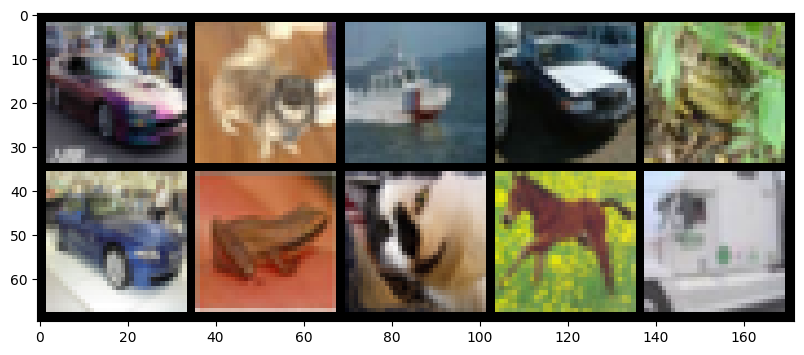

In [ ]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(6*6*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,6*6*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [ ]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
for param in model.parameters():
  print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch: 1000 [ 10000/50000]  loss: 2.08479738  accuracy:  26.310%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.86035669  accuracy:  32.210%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 0.98036224  accuracy:  35.597%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.17383957  accuracy:  37.740%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.40289986  accuracy:  39.556%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.33619356  accuracy:  48.580%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.24109256  accuracy:  49.155%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.21758509  accuracy:  49.780%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.93761617  accuracy:  50.110%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.86942172  accuracy:  50.504%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.68727148  accuracy:  53.850%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.30205429  accuracy:  53.990%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.43821609  accuracy:  54.600%
epoch:  2  b

In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/Deep_learning-datasets/myCIFARmodel.pt")

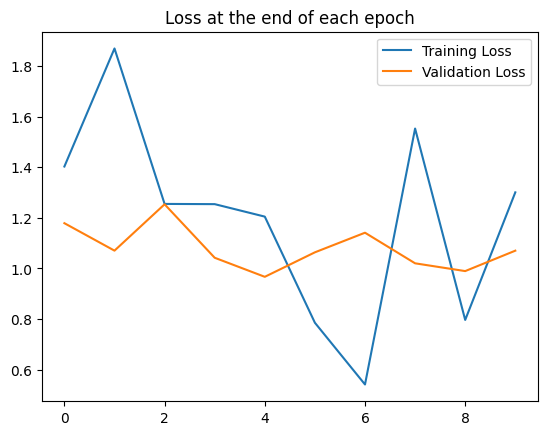

In [ ]:
plt.plot([t.detach().numpy() for t in train_losses],label='Training Loss')
plt.plot([t.detach().numpy() for t in test_losses],label='Validation Loss')
plt.title('Loss at the end of each epoch')
plt.legend()

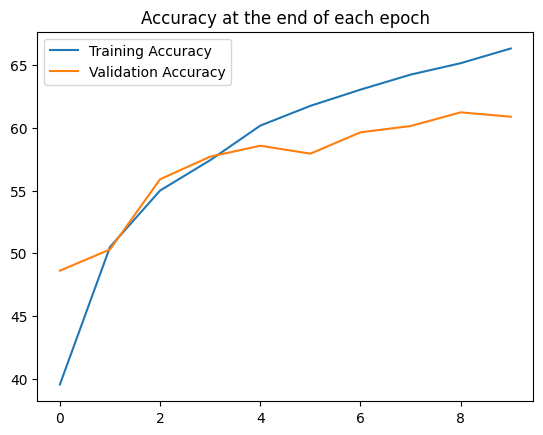

In [ ]:
plt.plot([t/500 for t in train_correct],label='Training Accuracy')
plt.plot([t/100 for t in test_correct],label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [ ]:
print(test_correct)

[tensor(4862), tensor(5031), tensor(5590), tensor(5770), tensor(5857), tensor(5794), tensor(5964), tensor(6014), tensor(6123), tensor(6088)]


In [ ]:
num_c = test_correct[-1]

In [ ]:
100*num_c/len(test_data)

tensor(60.8800)

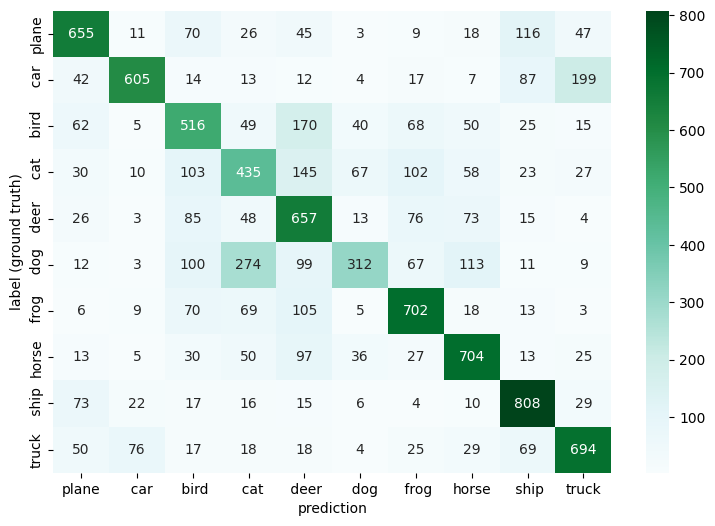

In [ ]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();